## **Project Configuration and Library Imports**

In [25]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,
)

from collections import Counter
import warnings

# Configuration
warnings.filterwarnings('ignore')
sns.set_theme()  # Updated seaborn theme
pd.set_option('display.max_columns', 100)
np.random.seed(42)

# Constants
DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv'
TARGET = 'Machine failure'
FEATURES = ['Air temperature [K]', 'Process temperature [K]',
            'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
TEST_SIZE = 0.2
VAL_SIZE = 0.25
RANDOM_STATE = 42

### **Data Pipeline Class Definition**

In [26]:
class DataPipeline:
    def __init__(self):
        self.df = None
        self.scaler = StandardScaler()

    def load_data(self):
        try:
            self.df = pd.read_csv(DATA_URL)
            return self
        except Exception as e:
            print(f"Error loading data: {e}")
            raise

    def preprocess(self):
        try:
            self.df[TARGET] = self.df[TARGET].astype(int)
            if self.df.isnull().sum().any():
                self.df.fillna(self.df.median(), inplace=True)
            return self
        except Exception as e:
            print(f"Error in preprocessing: {e}")
            raise

    def split_data(self):
        X = self.df[FEATURES]
        y = self.df[TARGET]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=VAL_SIZE, stratify=y_train, random_state=RANDOM_STATE
        )
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)
        return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, self.df

### **Custom Decision Tree Class Definition**

In [27]:
class DecisionTree:
    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
        def is_leaf(self): return self.value is not None

    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.feature_importances_ = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)
        self._compute_feature_importance(X.shape[1])

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if (depth >= self.max_depth or len(set(y)) == 1 or n_samples < self.min_samples_split):
            return self.Node(value=self._most_common_label(y))
        best_feat, best_thresh = self._best_split(X, y, n_features)
        if best_feat is None:
            return self.Node(value=self._most_common_label(y))
        left_idxs = X[:, best_feat] < best_thresh
        right_idxs = ~left_idxs
        left = self._grow_tree(X[left_idxs], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs], y[right_idxs], depth + 1)
        return self.Node(best_feat, best_thresh, left, right)

    def _best_split(self, X, y, n_features):
        best_gain, split_idx, split_thresh = -1, None, None
        for feat_idx in range(n_features):
            for threshold in np.unique(X[:, feat_idx]):
                gain = self._information_gain(X[:, feat_idx], y, threshold)
                if gain > best_gain:
                    best_gain, split_idx, split_thresh = gain, feat_idx, threshold
        return split_idx, split_thresh

    def _information_gain(self, X_column, y, threshold):
        parent_entropy = self._entropy(y)
        left_idxs = X_column < threshold
        right_idxs = ~left_idxs
        if len(y[left_idxs]) == 0 or len(y[right_idxs]) == 0:
            return 0
        n = len(y)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        return parent_entropy - ((len(y[left_idxs])/n)*e_l + (len(y[right_idxs])/n)*e_r)

    def _entropy(self, y):
        if len(y) == 0:
            return 0
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _most_common_label(self, y): return Counter(y).most_common(1)[0][0]

    def _traverse_tree(self, x, node):
        if node.is_leaf(): return node.value
        if x[node.feature] < node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _compute_feature_importance(self, n_features):
        self.feature_importances_ = np.zeros(n_features)
        self._count_splits(self.root)
        total = self.feature_importances_.sum()
        if total > 0:
            self.feature_importances_ /= total

    def _count_splits(self, node):
        if node.is_leaf(): return
        self.feature_importances_[node.feature] += 1
        self._count_splits(node.left)
        self._count_splits(node.right)

### **Custom Support Vector Machine (SVM) Class Definition**

In [28]:
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.loss_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.where(approx >= 0, 1, 0).astype(int)

### **Evaluation Framework for Model Performance**

In [29]:
class EvaluationFramework:
    @classmethod
    def run_full_analysis(cls, models, X_train, y_train, X_val, y_val, X_test, y_test):
        results = {}
        for name, model in models.items():
            print(f"\nTraining {name}")
            model.fit(X_train, y_train)
            print("\nValidation:")
            val = cls._evaluate(model, X_val, y_val)
            print("\nTest:")
            test = cls._evaluate(model, X_test, y_test)
            if hasattr(model, 'feature_importances_'):
                cls._plot_feature_importance(model, name)
            results[name] = {'val': val, 'test': test}
        return results

    @classmethod
    def _evaluate(cls, model, X, y):
        preds = model.predict(X)
        print(classification_report(y, preds))
        sns.heatmap(confusion_matrix(y, preds), annot=True, cmap="Blues", fmt="d")
        plt.title(f"Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
        return {
            'accuracy': accuracy_score(y, preds),
            'precision': precision_score(y, preds),
            'recall': recall_score(y, preds),
            'f1': f1_score(y, preds),
            'roc_auc': roc_auc_score(y, preds)
        }

    @classmethod
    def _plot_feature_importance(cls, model, name):
        sns.barplot(x=model.feature_importances_, y=FEATURES)
        plt.title(f'{name} - Feature Importance')
        plt.xlabel("Importance")
        plt.show()

### **Model Training, Evaluation, and Visualization**

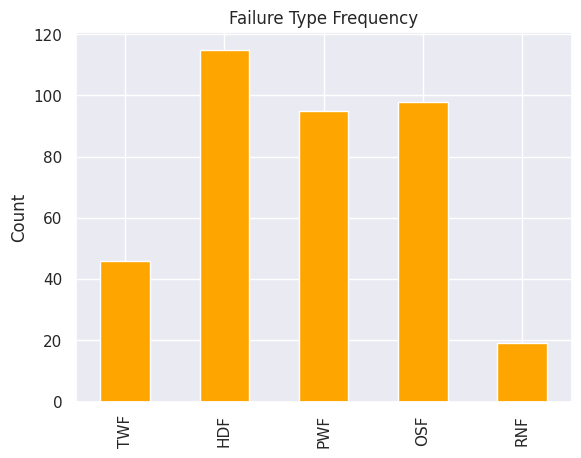

In [30]:
# Initialize and run pipeline
pipeline = DataPipeline().load_data().preprocess()
X_train, X_val, X_test, y_train, y_val, y_test, df = pipeline.split_data()

# Visualizations
# Bar chart: Failure Types
# Tool Wear Failure - occurs when tool wear exceeds a threshold
# Heat Dissipation - Failure occurs when heat dissipation is insufficient
# Power Failure - occurs when power supply is interrupted
# Overstrain Failure - occurs when machine components are overstrained
# Random Failure - occurs due to unpredictable reasons
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df[failure_types].sum().plot(kind='bar', title='Failure Type Frequency', color='orange')
plt.ylabel("Count")
plt.show()


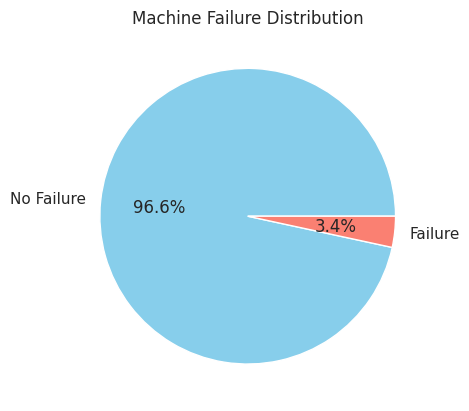

In [31]:

# Pie chart: Machine failure rate
df[TARGET].value_counts().plot.pie(autopct='%1.1f%%', labels=['No Failure', 'Failure'], colors=['skyblue', 'salmon'])
plt.title("Machine Failure Distribution")
plt.ylabel("")
plt.show()



Training Decision Tree

Validation:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.72      0.31      0.43        68

    accuracy                           0.97      2000
   macro avg       0.85      0.65      0.71      2000
weighted avg       0.97      0.97      0.97      2000



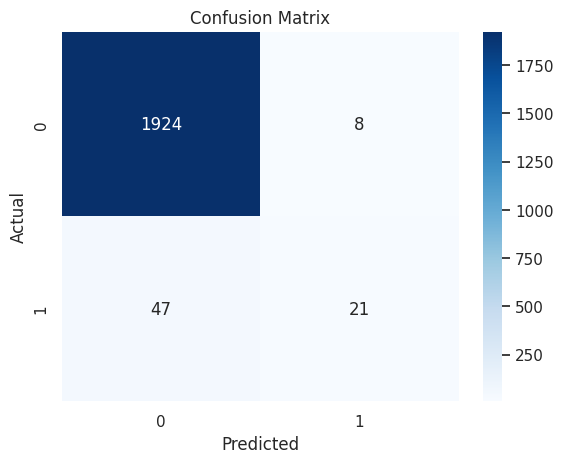


Test:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.84      0.38      0.53        68

    accuracy                           0.98      2000
   macro avg       0.91      0.69      0.76      2000
weighted avg       0.97      0.98      0.97      2000



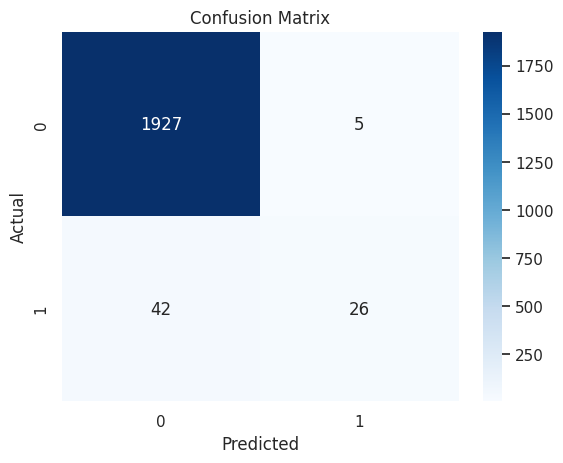

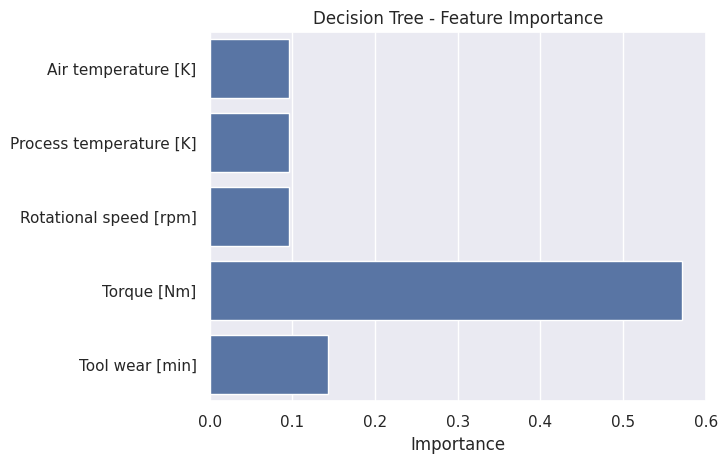


Training SVM

Validation:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1932
           1       0.00      0.00      0.00        68

    accuracy                           0.97      2000
   macro avg       0.48      0.50      0.49      2000
weighted avg       0.93      0.97      0.95      2000



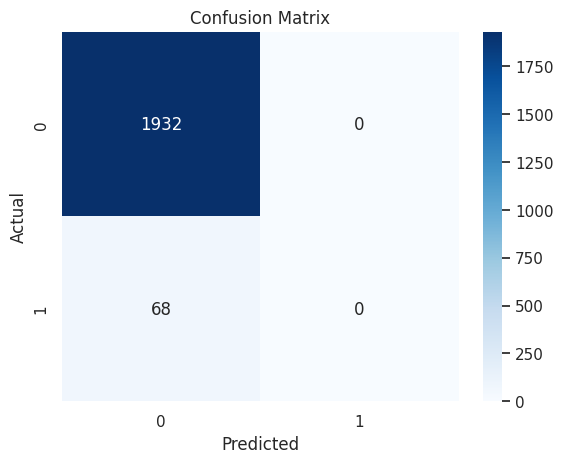


Test:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1932
           1       0.00      0.00      0.00        68

    accuracy                           0.97      2000
   macro avg       0.48      0.50      0.49      2000
weighted avg       0.93      0.97      0.95      2000



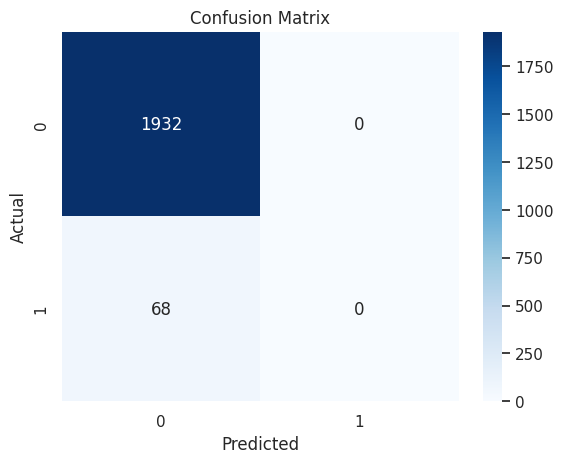

In [32]:

# Model evaluation
models = {
    "Decision Tree": DecisionTree(max_depth=5, min_samples_split=10),
    "SVM": SVM(learning_rate=0.001, lambda_param=0.01, n_iters=2000)
}

results = EvaluationFramework.run_full_analysis(models, X_train, y_train, X_val, y_val, X_test, y_test)


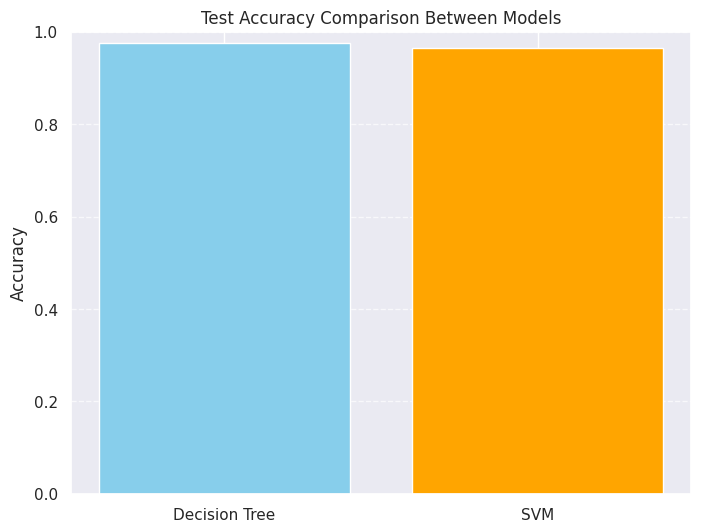


✅ Comparison Summary:
Decision Tree - Accuracy: 0.9765, F1: 0.5253
SVM - Accuracy: 0.9660, F1: 0.0000


In [33]:

# Plot accuracy comparison
accuracies = [results[m]['test']['accuracy'] for m in results]
model_names = list(results.keys())

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['skyblue', 'orange'])
plt.title("Test Accuracy Comparison Between Models")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print summary
print("\n✅ Comparison Summary:")
for model, scores in results.items():
    print(f"{model} - Accuracy: {scores['test']['accuracy']:.4f}, F1: {scores['test']['f1']:.4f}")